In [1]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import *
from keras.datasets import mnist
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Local imports
from unet import unet_cell, LEAKY_RELU_ALPHA, BATCH_NORM_MOMENTUM
from builders import build_upscaler, build_upscaler_v2, build_discriminator
from utils import reduce_resolution

batch_size = 20
n_channels = 1
GRADIENT_PENALTY_WEIGHT = 10
import WGAN_utils
from WGAN_utils import wasserstein_loss, gradient_penalty_loss, RandomWeightedAverage
WGAN_utils.batch_size=batch_size

Using TensorFlow backend.


In [2]:
# Load MNIST training data
(X_train, _), (_, _) = mnist.load_data() # No need for labels or test set
X_train = X_train.reshape(-1, 28, 28, 1)
X_train = X_train / 255.0 # Normalize

In [3]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))
# TODO: dimensions of low_res_input should probably be divisible 
# by 2**{num_layers}
high_res_input = Input(shape=(None, None, 1)) # This should really have dimensions twice that of low_res_input

# Build upscaler / discriminator
upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(28, 28),
    resize_method='nearest_neighbor',
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)
preliminary_discriminator = build_discriminator(low_res_input, high_res_input, 
                                                batch_normalization=False, 
                                                activation_in_final_layer=False) # Use default parameters


# Define optimizers and compile models
upscaler_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
upscaler.compile(loss='binary_crossentropy', 
                 optimizer=upscaler_optimizer)

# Defines the forward pass for the discriminator.  This will be used for the combined
# model when training the generator, but the gradient loss function still has to
# be defined so it can be used in training the discriminator.  This model will
# be used to calculate the gradient loss and so has to be compiled now.
discriminator_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
preliminary_discriminator.compile(loss='binary_crossentropy', 
                      optimizer=discriminator_optimizer, 
                      metrics=['accuracy'])

# We will compile the discriminator model before the combined model for the generator
# so the generator's weights should be frozen.
preliminary_discriminator.trainable = True
upscaler.trainable = False

# We need sample images produced by the generator and so that we can take a weighted
# average of the generated images and the real images to stochastically determine the
# effective gradients by passing this weighted average through the discriminator. We
# also use the inputs and outputs defined here to define the full discriminator model.
generator_input = Input(shape=(None, None, 1))
generated_samples = upscaler(generator_input)
discriminator_output_from_generator = preliminary_discriminator([generator_input, generated_samples])

low_res_input_for_discriminator = Input(shape=(None, None, 1))
real_samples = Input(shape=(None, None, 1))
discriminator_output_from_real_samples = preliminary_discriminator([low_res_input_for_discriminator, real_samples])

# We also need to generate weighted-averages of real and generated samples, to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples, generated_samples])
# We then run these samples through the discriminator as well. Note that we never really use the discriminator
# output for these samples - we're only running them to get the gradient norm for the gradient penalty loss.
averaged_samples_out = preliminary_discriminator([generator_input, averaged_samples])

# The gradient penalty loss function requires the input averaged samples to get gradients. However,
# Keras loss functions can only have two arguments, y_true and y_pred. We get around this by making a partial()
# of the function with the averaged samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gradient_penalty'  # Functions need names or Keras will throw an error

# Define model and compile it
discriminator = Model(inputs=[generator_input, low_res_input_for_discriminator, real_samples],
                            outputs=[discriminator_output_from_generator,
                                     discriminator_output_from_real_samples,
                                     averaged_samples_out])

discriminator.compile(optimizer=discriminator_optimizer,
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss], 
                      metrics = None)

# Freeze the discriminator weights and allow the generator to train
preliminary_discriminator.trainable = False
upscaler.trainable = True

# Define the input and output of the combined model.
low_res_input_for_combined_model = Input(shape=(None, None, 1))
upscaled_imgs = upscaler(low_res_input_for_combined_model)
valid = preliminary_discriminator([low_res_input_for_combined_model, upscaled_imgs])

# The combined model  (stacked upscaler and discriminator) takes
# low-res image as input and returns an upsampled image from the 
# upscaler and a validity score given by the discriminator
combined = Model(low_res_input_for_combined_model, [valid, upscaled_imgs])
combined.compile(loss=[wasserstein_loss, 'mean_absolute_error'], 
                 optimizer=upscaler_optimizer, 
                 metrics = None)
# Notice: the combined model was compiled *after* freezing the discriminator's weights

print('combined summary')
combined.summary()
print('discriminator summary')
discriminator.summary()
print('preliminary_discriminator summary')
preliminary_discriminator.summary()
print('upscaler summary')
upscaler.summary()

combined summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28, 1)    135047      input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            120497      input_6[0][0]                    
                                                                 model_1[2][0]                    
Total params: 255,544
Trainable params: 134,123
Non-trainable params: 121,421
__________________________________________________________________________________________________
discriminator 

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [4]:
# Define training parameters
train_steps = 1000
print_every_n_steps = 20
print_results = True
plot_results = True
repeat_discriminator_training_n_times = 1
# batch_size defined in first cell

# Create a dictionary for storing training metrics over time
training_metrics = {
    'step': [],
    'd_total_loss': [],
    'd_w_fake_loss': [],
    'd_w_real_loss': [],
    'd_grad_loss': [],
    'g_total_loss': [], 
    'g_w_loss': [], 
    'g_MSE_loss': [], 
    'g_MSE_test_loss': []
}

# We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
# negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
# gradient_penalty loss function and is not used.
positive_y = np.ones((batch_size, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 20:
    [D losses: Total=8.791687, Wass_fake=-0.655421, Wass_real=0.360508, Wass_grad=9.086599]
    [G losses: Total=1.131026, Wass=0.790708, MSE_train=0.340318, MSE_test=0.189013]


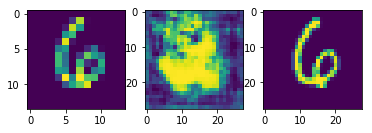

Step 40:
    [D losses: Total=-1.379593, Wass_fake=-7.271420, Wass_real=5.472848, Wass_grad=0.418979]
    [G losses: Total=8.614305, Wass=8.152861, MSE_train=0.461445, MSE_test=0.352805]


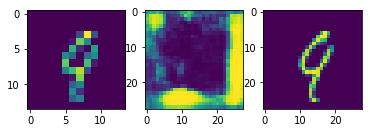

Step 60:
    [D losses: Total=-0.447711, Wass_fake=-5.947518, Wass_real=5.289076, Wass_grad=0.210731]
    [G losses: Total=6.536325, Wass=6.067538, MSE_train=0.468786, MSE_test=0.380101]


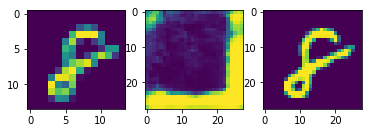

Step 80:
    [D losses: Total=-1.450850, Wass_fake=-3.555539, Wass_real=1.928284, Wass_grad=0.176405]
    [G losses: Total=4.042100, Wass=3.591534, MSE_train=0.450566, MSE_test=0.367244]


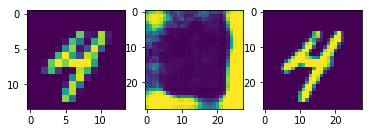

Step 100:
    [D losses: Total=-3.268255, Wass_fake=-2.337251, Wass_real=-1.280776, Wass_grad=0.349772]
    [G losses: Total=2.857135, Wass=2.435285, MSE_train=0.421850, MSE_test=0.350854]


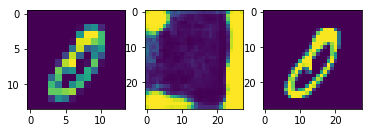

Step 120:
    [D losses: Total=-3.151516, Wass_fake=-1.473196, Wass_real=-1.975196, Wass_grad=0.296875]
    [G losses: Total=2.815508, Wass=2.500747, MSE_train=0.314761, MSE_test=0.224084]


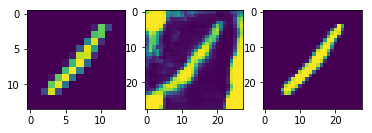

Step 140:
    [D losses: Total=-2.650417, Wass_fake=-3.524035, Wass_real=0.728516, Wass_grad=0.145102]
    [G losses: Total=4.026605, Wass=3.732654, MSE_train=0.293951, MSE_test=0.199339]


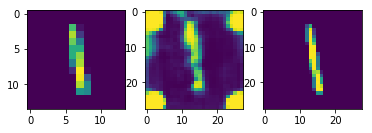

Step 160:
    [D losses: Total=-3.084533, Wass_fake=-3.751354, Wass_real=0.415145, Wass_grad=0.251676]
    [G losses: Total=3.998322, Wass=3.750329, MSE_train=0.247994, MSE_test=0.178499]


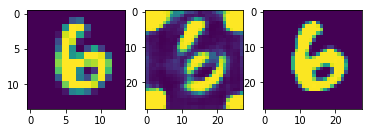

Step 180:
    [D losses: Total=-3.998052, Wass_fake=-7.609708, Wass_real=2.967379, Wass_grad=0.644277]
    [G losses: Total=6.531865, Wass=6.296545, MSE_train=0.235320, MSE_test=0.163726]


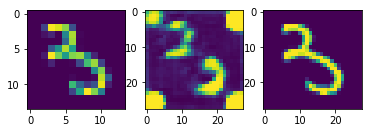

Step 200:
    [D losses: Total=-4.568726, Wass_fake=-7.978116, Wass_real=3.052165, Wass_grad=0.357225]
    [G losses: Total=8.878555, Wass=8.682183, MSE_train=0.196372, MSE_test=0.133135]


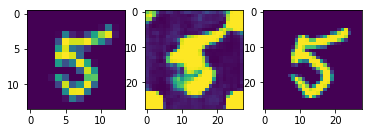

Step 220:
    [D losses: Total=-4.642004, Wass_fake=-8.587354, Wass_real=3.692083, Wass_grad=0.253268]
    [G losses: Total=9.177111, Wass=8.987271, MSE_train=0.189840, MSE_test=0.116488]


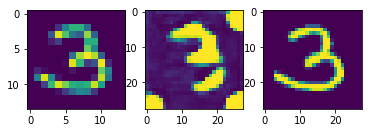

Step 240:
    [D losses: Total=-4.366435, Wass_fake=-9.028612, Wass_real=4.609461, Wass_grad=0.052716]
    [G losses: Total=11.909650, Wass=11.736057, MSE_train=0.173592, MSE_test=0.083678]


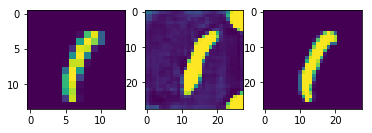

Step 260:
    [D losses: Total=-4.054980, Wass_fake=-10.018546, Wass_real=5.439889, Wass_grad=0.523677]
    [G losses: Total=10.572578, Wass=10.421858, MSE_train=0.150720, MSE_test=0.058338]


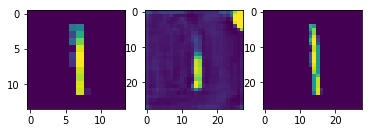

Step 280:
    [D losses: Total=-3.158817, Wass_fake=-10.542077, Wass_real=7.139464, Wass_grad=0.243796]
    [G losses: Total=8.871632, Wass=8.729811, MSE_train=0.141821, MSE_test=0.042748]


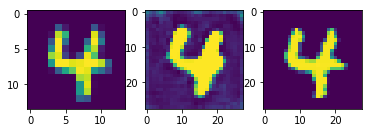

Step 300:
    [D losses: Total=-3.233360, Wass_fake=-10.530726, Wass_real=7.147817, Wass_grad=0.149550]
    [G losses: Total=10.160112, Wass=10.024149, MSE_train=0.135964, MSE_test=0.035877]


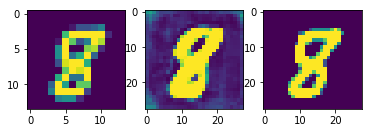

Step 320:
    [D losses: Total=-2.219048, Wass_fake=-10.186641, Wass_real=7.800869, Wass_grad=0.166724]
    [G losses: Total=9.070393, Wass=8.952334, MSE_train=0.118058, MSE_test=0.029963]


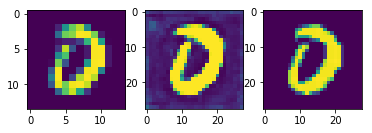

Step 340:
    [D losses: Total=-3.721591, Wass_fake=-10.627643, Wass_real=6.687230, Wass_grad=0.218821]
    [G losses: Total=13.656407, Wass=13.539635, MSE_train=0.116773, MSE_test=0.028261]


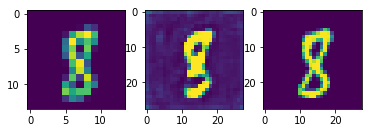

Step 360:
    [D losses: Total=-2.782579, Wass_fake=-8.898367, Wass_real=6.003499, Wass_grad=0.112289]
    [G losses: Total=9.637310, Wass=9.529976, MSE_train=0.107334, MSE_test=0.027090]


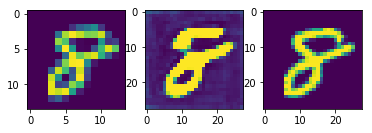

Step 380:
    [D losses: Total=-2.307777, Wass_fake=-7.073228, Wass_real=4.759273, Wass_grad=0.006178]
    [G losses: Total=8.828362, Wass=8.729041, MSE_train=0.099320, MSE_test=0.022926]


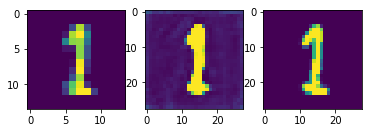

Step 400:
    [D losses: Total=-1.535486, Wass_fake=-8.325508, Wass_real=6.763596, Wass_grad=0.026427]
    [G losses: Total=7.259208, Wass=7.166341, MSE_train=0.092867, MSE_test=0.020806]


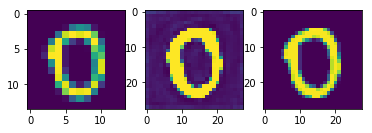

Step 420:
    [D losses: Total=-1.293685, Wass_fake=-8.053238, Wass_real=6.703026, Wass_grad=0.056527]
    [G losses: Total=7.455772, Wass=7.358037, MSE_train=0.097735, MSE_test=0.020203]


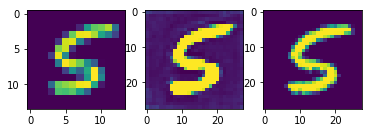

Step 440:
    [D losses: Total=-1.828912, Wass_fake=-9.216502, Wass_real=7.271284, Wass_grad=0.116307]
    [G losses: Total=8.591303, Wass=8.503917, MSE_train=0.087386, MSE_test=0.018681]


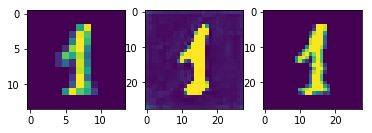

Step 460:
    [D losses: Total=-1.529102, Wass_fake=-6.262870, Wass_real=4.615172, Wass_grad=0.118596]
    [G losses: Total=5.567188, Wass=5.487423, MSE_train=0.079765, MSE_test=0.017223]


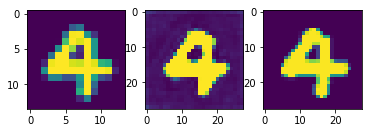

KeyboardInterrupt: 

In [5]:
test_data = X_train[:20]
for step in range(1, train_steps + 1):
    
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    num_images = len(X_train)
    for train_discriminator in range(repeat_discriminator_training_n_times):
        random_idxs = np.random.randint(num_images, size=batch_size)
        imgs_to_pass_through_upscaler = X_train[random_idxs]
        low_res_imgs_to_pass_through_upscaler = reduce_resolution(imgs_to_pass_through_upscaler)

        random_idxs = np.random.randint(num_images, size=batch_size)
        real_imgs = X_train[random_idxs]
        low_res_imgs_to_pass_through_discriminator = reduce_resolution(real_imgs)

        # Train the discriminator
        d_loss = discriminator.train_on_batch( 
            x=[low_res_imgs_to_pass_through_upscaler, low_res_imgs_to_pass_through_discriminator, real_imgs], # Training data
            y=[negative_y, positive_y, dummy_y]) # Labels
    
    # ---------------------
    #  Train upscaler
    # ---------------------

    random_idxs = np.random.randint(num_images, size=batch_size)
    original_imgs = X_train[random_idxs]
    new_low_res_imgs = reduce_resolution(original_imgs)
    
    # Train the upscaler
    g_loss = combined.train_on_batch(
        x=new_low_res_imgs, 
        y=[positive_y, original_imgs])
        
    if step % print_every_n_steps == 0:
        gen_imgs = upscaler.predict(reduce_resolution(test_data))
        MSE_test_loss = np.average((gen_imgs-test_data)**2)
        # Store metrics over time
        training_metrics['step'].append(step)
        training_metrics['d_total_loss'].append(d_loss[0])
        training_metrics['d_w_fake_loss'].append(d_loss[1])
        training_metrics['d_w_real_loss'].append(d_loss[2])
        training_metrics['d_grad_loss'].append(d_loss[3])
        training_metrics['g_total_loss'].append(g_loss[0])
        training_metrics['g_w_loss'].append(g_loss[1])
        training_metrics['g_MSE_loss'].append(g_loss[2])
        training_metrics['g_MSE_test_loss'].append(MSE_test_loss)
        
        # Print current metrics
        if print_results:
            print("Step {}:".format(step))
            print("    [D losses: Total={:0.6f}, Wass_fake={:0.6f}, Wass_real={:0.6f}, Wass_grad={:0.6f}]".format(
                training_metrics['d_total_loss'][-1],
                training_metrics['d_w_fake_loss'][-1],
                training_metrics['d_w_real_loss'][-1],
                training_metrics['d_grad_loss'][-1]))
            print("    [G losses: Total={:0.6f}, Wass={:0.6f}, MSE_train={:0.6f}, MSE_test={:0.6f}]".format(
                training_metrics['g_total_loss'][-1],
                training_metrics['g_w_loss'][-1],
                training_metrics['g_MSE_loss'][-1], 
                training_metrics['g_MSE_test_loss'][-1]))
        
        # Plot example low_res vs upsampling vs original
        if plot_results:
            gen_imgs = upscaler.predict(low_res_imgs_to_pass_through_discriminator)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(low_res_imgs_to_pass_through_discriminator[0, :, :, 0])
            ax2.imshow(gen_imgs[0, :, :, 0])
            ax3.imshow(real_imgs[0, :, :, 0])
            plt.show()

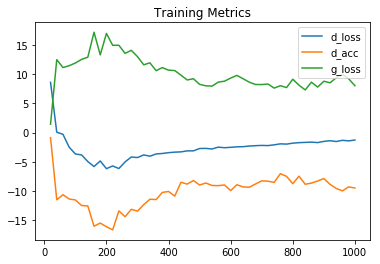

In [6]:
steps = training_metrics['step']
for key, values in training_metrics.items():
    if key == 'step': continue
    plt.plot(steps, values, label=key)
plt.title('Training Metrics')
plt.legend();

In [7]:
def save_models():
    upscaler.save('./models/upscaler_mnist.h5')
    discriminator.save('./models/discriminator_mnist.h5')
    combined.save('./models/combined_mnist.h5')

In [8]:
def show_examples():
    from keras.models import load_model

    # Load the upscaler
    upscaler = load_model('./models/upscaler_mnist.h5')

    # Upsample five images
    fi = 314 # First index
    images = X_train[fi:fi + 5]
    upsampled = upscaler.predict(images)
    upupsampled = upscaler.predict(upsampled)

    # Create a figure showing the results
    for i, (original, up, upup) in enumerate(zip(images, upsampled, upupsampled)):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        if i == 0:
            fig.suptitle("Original vs Upsampled vs Twice Upsampled")
        ax1.imshow(original[:, :, 0])
        ax2.imshow(up[:, :, 0])
        ax3.imshow(upup[:, :, 0])
        plt.show()

In [9]:
# save_models()
# show_examples()

# Transfering weights to model that produces larger outputs

In [10]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))

# Build upscaler with different output size
new_upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(128, 128),  # Previous output size was (28, 28)
    resize_method='bicubic', # Notice: We've even changed resize method from NN to bicubic
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)

# Compile the new upscaler
new_upscaler_optimizer = Adam(0.001, 0.5)
new_upscaler.compile(loss='binary_crossentropy', 
                     optimizer=new_upscaler_optimizer)

# Transfer weights from original upscaler to new upscaler
for new_layer, pretrained_layer in zip(new_upscaler.layers, upscaler.layers):
    learned_weights = pretrained_layer.get_weights()
    new_layer.set_weights(learned_weights)

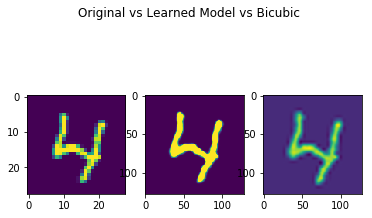

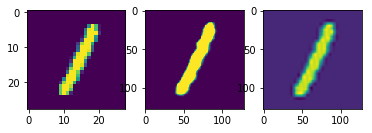

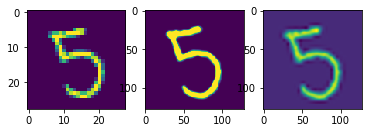

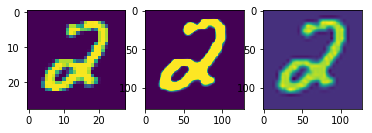

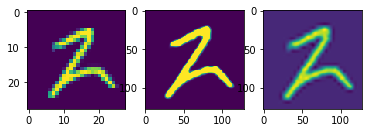

In [11]:
fi = 314 # First index
images = X_train[fi:fi+5] # Select five images
upsampled = new_upscaler.predict(images)

# Compare our model to vanilla bicubic resize:
with tf.Session() as sess:
    bicubic = sess.run(tf.image.resize_bicubic(images, (128, 128), align_corners=True))

# Create a figure showing the results
for i, (original, up, control) in enumerate(zip(images, upsampled, bicubic)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    if i == 0:
        fig.suptitle("Original vs Learned Model vs Bicubic")
    ax1.imshow(original[:, :, 0])
    ax2.imshow(up[:, :, 0])
    ax3.imshow(control[:, :, 0])
    plt.show()